In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
from IPython.display import display, HTML

In [2]:
#Just to have each print in the same row
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [3]:
r'''
trusted_data_w_ocupacion: *trusted_data* with actual ocupacion included.
    path: r'C:\Users\ing_l\Tesis grado\Data\BD_parking_trusted_data_ocupacion.csv'
    
data_w_operacion: (DataFrame) data with the corresponding operacion (Entrada/Salida).
    path: C:\Users\ing_l\Tesis grado\Data\SUMO_data_w_operacion.csv

'''

trusted_data_path_w_ocupacion = r'C:\Users\ing_l\Tesis grado\Data\BD_parking_trusted_data_ocupacion.csv'
data_w_operacion_path = r'C:\Users\ing_l\Tesis grado\Data\SUMO_data_w_operacion.csv'

In [4]:
def add_ocupacion(d, street, inplace=False):
    '''
    Includes a new column called ocupacion and adds one to a row
        if its an "Entrada" and substract one if its "Salida".
    
    Parameters:
        d: (DataFrame) dataframe model to include the new column
        inplace: (Boolean) if use a reference of d or make a copy instead.
        
    Return:
        out: the d reference or copy that contains the new column ocupacion
            with the correct values.
    
    '''
    def sum_ocup(row):
        '''
        Just for the apply func. If the row value is Entrada we sum 1,
        otherwise we subs 1.
        On each day we restart the actual_ocup.
        '''
        nonlocal actual_ocup, last_day

        if pd.to_datetime(row['fecha']).day != last_day:
            actual_ocup = 0
            last_day = pd.to_datetime(row['fecha']).day

        if row['operacion'] == 'Entrada':
            actual_ocup += 1
        else:
            if row['operacion'] == 'Salida':
                if actual_ocup > 0:
                    actual_ocup -= 1
        return actual_ocup

    #To use a reference or a copy of the input
    if inplace:
        out = d
    else:
        out = d.copy()

    out['fecha'] = out['fecha_hora'].apply(lambda x: pd.Timestamp(x).date())

    actual_ocup = 0
    last_day = pd.to_datetime(out['fecha'].min()).day
    out.loc[out['id_cuadra'] == street, 'ocupacion'] = out.loc[out['id_cuadra'] == street, ['operacion', 'fecha']].apply(sum_ocup, axis=1)

    out.drop('fecha', axis=1, inplace=True)

    if not inplace:
        return out

In [5]:
def reorder_españa(data, inplace=False):
    #Keep only one España street.
    # ESTO ESTA MAL TENGO QUE SUMAR EL OCUPADO SINO NO SIRVE
    if inplace:
        out = data
    else:
        out = data.copy()
        
    original = 85
    to_del = 93
    for i in range(91-85+1):
        out.loc[out.id_cuadra == to_del+i, 'id_cuadra'] = out.loc[out.id_cuadra == original+i, 'id_cuadra'].iloc[0]
        out.loc[out.id_cuadra == to_del+i, 'direccion'] = out.loc[out.id_cuadra == original+i, 'direccion'].iloc[0]

    out.sort_values(by=['id_cuadra','fecha_hora'], inplace=True, ascending=True)
    
    for i in range(91-85+1):
        add_ocupacion(out, street=original+i, inplace=True)

In [6]:
SUMO_data = pd.read_csv(data_w_operacion_path)
SUMO_data.rename(columns={'fecha_tiempo': 'fecha_hora'}, inplace=True)
#SUMO_data['fecha_hora'] = SUMO_data['fecha_hora'].apply(lambda x: pd.Timestamp(x))

#We dont want the SUMO office to appear in any data, cause there is no place to park
SUMO_data = SUMO_data.loc[SUMO_data.id_cuadra != 50]

#We only want one españa per street, but we need to correct the ocupacion
reorder_españa(SUMO_data, inplace=True)

BD_parking_data = pd.read_csv(trusted_data_path_w_ocupacion)

In [7]:
#Weekday data FOR SUMO
weekday_data = SUMO_data.copy()
weekday_data['dia de semana'] = weekday_data['fecha_hora'].apply(lambda x: pd.Timestamp(x).weekday())
#0:Monday 1:Tuesday 2:Wednesday 3:Thursday 4:Friday 5:Saturday 6:Sunday
weekday = 0
weekday_data = weekday_data.loc[weekday_data['dia de semana'] == 0]

# Choose the data

In [8]:
#DF to process...
#You can put on data any filter you want. If you put only monday data all the graphs
#below will be for monday values...
data = SUMO_data.copy()
#data = weekday_data.copy()
#data = BD_parking_data.copy()

#Street to process...
#From 2 to 92 without 50
street = 59

#Date to process...
#Select a number from 0 to data['fecha_hora'] len.
date_n = 1

def modif_date(data, n):
    '''n is the number of the date (e.g. 2 is the second date in the data df)'''
    if date_n < len(data):
        date = data['fecha_hora'].apply(lambda x: pd.Timestamp(x).date()).drop_duplicates().iloc[date_n]
    else:
        date = data['fecha_hora'].apply(lambda x: pd.Timestamp(x).date()).drop_duplicates().iloc[len(data)-1]
    return pd.Timestamp(date).date()

date = modif_date(data, date_n)

hour = 10

## Cuadras donde más se estaciona (SUMO)

In [9]:
def get_max_ocupacion(data):
    '''
    Obtain the max ocupacion per street.
    
    Parameters:
        data: (DataFrame) a DataFrame containing all the data or only for
        one day, e.g. only with the monday data.
        
    Returns:
        max_ocupacion: all max ocupation for all streets
        max_max_ocupacion: max_ocupacion.tail(10)
        less_max_ocupacion: max_ocupacion.head(10)
    '''
    
    max_ocupacion = data.copy()
    max_ocupacion = max_ocupacion[['id_cuadra','ocupacion_max', 'lugares_cuadra']].groupby(by='id_cuadra').max().reset_index()
    max_ocupacion = max_ocupacion.sort_values(by='ocupacion_max')

    max_ocupacion = max_ocupacion.merge(pd.read_csv(r'C:\Users\ing_l\Tesis grado\Data\Extra_data\idcuadra_to_direccion.csv'))

    less_max_ocupacion = max_ocupacion[['id_cuadra','direccion','ocupacion_max','lugares_cuadra']].head(10).reset_index(drop=True)
    max_max_ocupacion = max_ocupacion[['id_cuadra','direccion','ocupacion_max','lugares_cuadra']].tail(10).reset_index(drop=True)
    
    max_max_ocupacion = max_max_ocupacion.sort_values(by='ocupacion_max',ascending=False).reset_index(drop=True)
    return max_ocupacion, max_max_ocupacion, less_max_ocupacion

In [10]:
max_ocupacion, max_max_ocupacion, less_max_ocupacion = get_max_ocupacion(data)

In [11]:
display(max_max_ocupacion)

,id_cuadra,direccion,ocupacion_max,lugares_cuadra
0,59,Yrigoyen 655,32,48.0
1,32,Sarmiento 453,27,27.0
2,14,Rodriguez 464,27,30.0
3,33,Sarmiento 755,23,32.0
4,75,Maipu 333,23,31.0
5,13,General Pinto 343,22,27.0
6,11,San Martín 658,22,30.0
7,4,Rodriguez 552,22,28.0
8,21,Belgrano 540,21,29.0
9,80,General Paz 447,21,36.0


In [12]:
display(less_max_ocupacion)

,id_cuadra,direccion,ocupacion_max,lugares_cuadra
0,92,Tribunal de Faltas,1,NaN
1,78,Maipu 953,5,14.0
2,85,Av. España 359,5,7.0
3,25,Belgrano 958,6,13.0
4,77,Maipu 857,6,15.0
5,55,14 de Julio 467,7,13.0
6,69,14 de Julio 657,7,10.0
7,88,Av. España 647,7,11.0
8,87,Av. España 545,8,10.0
9,41,Mitre 446,8,16.0


### Para esto todavia faltaria tener mas datos y poder deducir algo del maximo valor posible. Por ahora ningun dato tiene sentido y por la poca cantidad tampoco puedo deducir mucho.

## Cuadras de mas y menos transito (input-ouputs) (SUMO)

In [13]:
def traffic_density(data):
    '''
    Obtain the traffic density (how much in-outs) per street.
    
    Parameters:
        SUMO_data: (DataFrame) a DataFrame containing all the data or only for
        one day, e.g. only with the monday data.
        
    Returns:
        traffic: all traffic density for all streets
        max_traffic: traffic.tail(10)
        min_traffic: traffic.head(10)
    '''
    traffic = data.copy()
    traffic = traffic[['id_cuadra','direccion']].groupby(by='id_cuadra').count().reset_index()
    traffic.rename(columns={'direccion': 'in-outs'}, inplace=True)
    traffic = traffic.sort_values(by='in-outs')
    traffic = traffic.merge(pd.read_csv(r'C:\Users\ing_l\Tesis grado\Data\Extra_data\idcuadra_to_direccion.csv'))
    max_traffic = traffic[['id_cuadra','direccion','in-outs']].tail(10).sort_values(by='in-outs', ascending=False).reset_index(drop=True)
    min_traffic = traffic[['id_cuadra','direccion','in-outs']].head(10).reset_index(drop=True)
    return traffic, max_traffic, min_traffic

In [14]:
_, max_traffic, min_traffic = traffic_density(data)

In [15]:
display(min_traffic)
display(max_traffic)

,id_cuadra,direccion,in-outs
0,92,Tribunal de Faltas,7
1,77,Maipu 857,153
2,71,14 de Julio 847,161
3,78,Maipu 953,181
4,79,General Paz 347,217
5,24,Belgrano 868,218
6,70,14 de Julio 767,219
7,85,Av. España 359,225
8,25,Belgrano 958,243
9,40,Mitre 348,286


,id_cuadra,direccion,in-outs
0,59,Yrigoyen 655,1331
1,11,San Martín 658,1280
2,6,General Pinto 759,1219
3,4,Rodriguez 552,1173
4,45,Alem 480,1154
5,89,Av. España 737,1144
6,46,Alem 556,1091
7,5,9 de Julio 441,1079
8,33,Sarmiento 755,1057
9,22,Belgrano 768,1043


## To plot day activity graphs

In [16]:
def get_filtered_time(plot_data, k=5):
    '''
    Obtains a dataframe with fixed dates to plot
    
    Parameters: 
        plot_data_date: dataframe containing the fecha_hora values of the plotted data
        k: how much dates will appear in the graph
        
    Returns: a dataframe containing only k dates and empty values
    '''
    
    #Get the timestamp of the fecha_hora column
    time = plot_data['fecha_hora'].reset_index(drop=True).apply(lambda x: pd.Timestamp(x)).copy()
    
    #Obtain the nearest row to 13:00hs
    '''same_hour = time.apply(lambda x: x.hour == 13)
    same_minutes = time.apply(lambda x: x.minute < 10)
    same_time = same_hour * same_minutes
    same_time_index = time[same_time].index[0]
    '''
    #Get the k values to be appended in the out (time var)
    size = len(time)
    pos = [0]
    vals = [str(time[pos[0]].time())]
    for i in range(1,k+1):
        pos.append(int(size*(i/k)) - 1)
        vals.append(str(time[pos[i]].time()))
    #pos[int(len(pos)/2)+1] = same_time_index
    #vals[int(len(vals)/2)+1] = str(time[pos[int(len(vals)/2)+1]].time())
    '''pos = [0, int(size*(1/4)), same_time_index, int(size*(3/4)), int(size-1)]
    val1 = str(time[pos[0]].time())
    val2 = str(time[pos[1]].time())
    val3 = str(time[pos[2]].time())
    val4 = str(time[pos[3]].time())
    val5 = str(time[pos[4]].time())
    '''
    #Fill with empty values the time Series
    time = pd.Series('', index=time.index)
    
    #Put all obtained values into time Series
    for i in range(k+1):
        time.iloc[pos[i]] = vals[i]
    '''time.iloc[pos[0]] = val1
    time.iloc[pos[1]] = val2
    time.iloc[pos[2]] = val3
    time.iloc[pos[3]] = val4
    time.iloc[pos[4]] = val5
    '''
    return time

In [17]:
def plot_line_graph(plot_data, date, street, max_ocup=30, name='Original', color='b', k=5):

    #Get the values for each date we have
    plot_data_date = plot_data.loc[plot_data.fecha == pd.Timestamp(date).date()].copy()

    #Obtaining the mean to plot in the title of the graph
    mean = plot_data_date['ocupacion'].mean()
    #Modify the plot size
    plt.rcParams['figure.figsize'] = (12,4)
    
    #The max value
    plt.ylim([0, max_ocup+1])

    #Just for the x axis, get the first, medium and last time value
    if k > len(plot_data_date):
        time = get_filtered_time(plot_data_date, len(plot_data_date))
    else:
        time = get_filtered_time(plot_data_date, k)
                
    #Set the label titles
    plt.xlabel('Time')
    plt.ylabel('Parked cars')
    plt.title('Parked cars in street nº{} along the day ({}). Mean parked cars: {}. Sample of {} parked cars'.format(street, date, mean, len(plot_data_date)))
    
    #Set the plot data for each graph (ax1,ax2,ax3)
    plt.plot(plot_data_date['fecha_hora'], plot_data_date['ocupacion'], label='{} date'.format(name), color=color)
    
    plt.xticks(plot_data_date['fecha_hora'], time)
    plt.legend()
    plt.show()

In [18]:
def get_max_min_mean_dates(to_plot_data, street, date):
    street_name = to_plot_data.loc[to_plot_data.id_cuadra == street, 'direccion'].iloc[0]

    plot_data = to_plot_data.loc[to_plot_data.id_cuadra == street, ['fecha_hora','ocupacion']].copy()

    plot_data['fecha'] = plot_data['fecha_hora'].apply(lambda x: pd.Timestamp(x).date())

    '''max_mean = plot_data.groupby(by='fecha').mean().max()[0]
    date_max_mean = plot_data.groupby(by='fecha').mean().reset_index()
    date_max_mean = date_max_mean.loc[date_max_mean['ocupacion'] == max_mean, 'fecha'].iloc[0]
    '''
    def search_date_of_mean(p_d, what, min_quantity=150):
        '''
        To search the day with *what* parked cars, but with at least
        min_quantity registers (rows)
        '''
        plot_data = p_d.copy()
        full_mean = plot_data.groupby(by='fecha').mean().reset_index()

        if what=='max':
            mean = full_mean['ocupacion'].max()
        elif what=='min':
            mean = full_mean['ocupacion'].min()

        date_of_mean = full_mean.loc[full_mean['ocupacion'] == mean, 'fecha'].iloc[0]
        
        #If the date min mean have values from 9hs to 20hs or more we want it, else no...
        plot_data_of_date = plot_data.loc[plot_data['fecha'] == date_of_mean, 'fecha_hora'].reset_index(drop=True)
        
        if (pd.Timestamp(plot_data_of_date.iloc[0]).time().hour < 9) and (pd.Timestamp(plot_data_of_date.iloc[len(plot_data_of_date)-1]).time().hour > 19):
            if min_quantity == 0:
                return date_of_mean
            elif len(plot_data_of_date) > min_quantity:
                return date_of_mean
            else:
                return search_date_of_mean(plot_data.loc[plot_data['fecha'] != date_of_mean], what, min_quantity)
        else:
            return search_date_of_mean(plot_data.loc[plot_data['fecha'] != date_of_mean], what, min_quantity)

    #Date when there was the max mean parked cars in select street
    date_max_mean = search_date_of_mean(plot_data, what='max', min_quantity=0)
    
    #Date when there was the min mean parked cars in select street
    date_min_mean = search_date_of_mean(plot_data, what='min', min_quantity=0)

    print(street_name)

    #Getting the max ocup to plot all the graphs with the same y-axis values
    max_ocup1 = plot_data.loc[plot_data['fecha'] == pd.Timestamp(date).date(),'ocupacion'].max()
    max_ocup2 = plot_data.loc[plot_data['fecha'] == pd.Timestamp(date_max_mean).date(), 'ocupacion'].max()
    max_ocup3 = plot_data.loc[plot_data['fecha'] == pd.Timestamp(date_min_mean).date(), 'ocupacion'].max()

    max_ocup = max(max_ocup1, max_ocup2, max_ocup3)
    
    return plot_data, date_max_mean, date_min_mean, max_ocup 

In [19]:
plot_data, date_max_mean, date_min_mean, max_ocup = get_max_min_mean_dates(data, street, date)

Yrigoyen 655


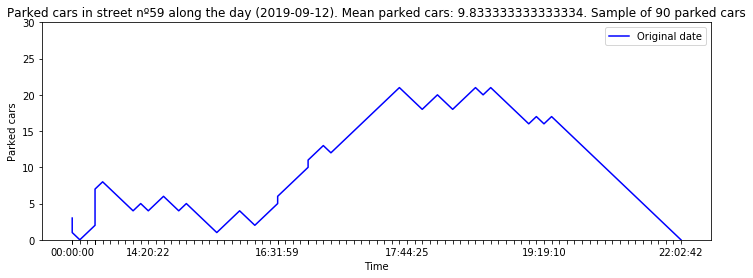

In [20]:
plot_line_graph(plot_data, date, street=street, max_ocup=max_ocup)

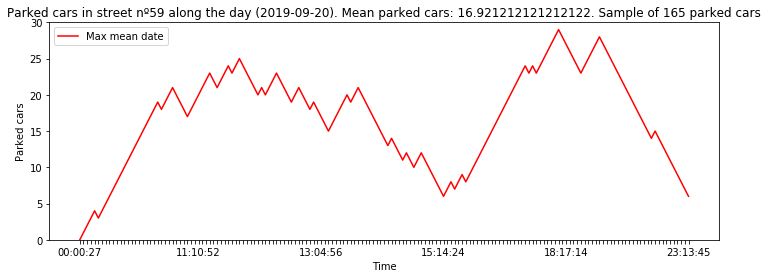

In [21]:
plot_line_graph(plot_data, date_max_mean, street=street, max_ocup=max_ocup, name='Max mean', color='r')

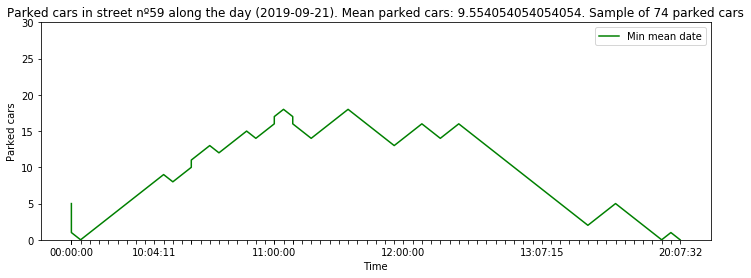

In [22]:
plot_line_graph(plot_data, date_min_mean, street=street, max_ocup=max_ocup, name='Min mean', color='g')

## En una ventana de tiempo la cantidad de entradas y salidas que se tienen para poder predecir donde se podrian liberar lugares para estacionar mas frecuentemente

In [23]:
def inputs_outputs_per_hour(data):
    '''
    Obtain the inputs and outputs (and the sub of both) per street.
    
    Parameters:
        SUMO_data: (DataFrame) a DataFrame containing all the data or only for
        one day, e.g. only with the monday data.
        
    Returns:
        in_out_per_hour: (DataFrame) df that contains the inputs, the outputs 
        and the sub: entradas-salidas.
    '''
    
    #Create column dia and tiempo just to obtain the inputs and outputs in an easy way
    in_out_per_hour= data.copy()
    in_out_per_hour = in_out_per_hour[['id_cuadra','fecha_hora','operacion']]
    in_out_per_hour['dia'] = in_out_per_hour['fecha_hora'].apply(lambda x: pd.Timestamp(x).date().day)
    in_out_per_hour['tiempo'] = in_out_per_hour['fecha_hora'].apply(lambda x: pd.Timestamp(x).time().hour)

    #Obtain 2 df, one with the count of the inputs and the other with the count of the outputs
    in_per_hour = in_out_per_hour.loc[in_out_per_hour['operacion'] == 'Entrada', ['dia','tiempo','id_cuadra', 'operacion']].groupby(by=['id_cuadra', 'dia','tiempo']).count()
    out_per_hour = in_out_per_hour.loc[in_out_per_hour['operacion'] == 'Salida', ['dia','tiempo','id_cuadra', 'operacion']].groupby(by=['id_cuadra', 'dia','tiempo']).count()
    in_per_hour.rename(columns={'operacion': 'entradas'}, inplace=True)
    out_per_hour.rename(columns={'operacion': 'salidas'}, inplace=True)

    #Obtain the mean of the inputs and outputs
    in_per_hour = in_per_hour.groupby(by=['id_cuadra','tiempo']).mean().reset_index()
    out_per_hour = out_per_hour.groupby(by=['id_cuadra','tiempo']).mean().reset_index()

    #Merge both in and out per hour to get the diff
    in_out_per_hour = in_per_hour.merge(out_per_hour, how='outer', on=['id_cuadra','tiempo'])
    in_out_per_hour.fillna(0, inplace=True)

    #Subs values
    in_out_per_hour['in - out'] = in_out_per_hour['entradas'] - in_out_per_hour['salidas']
    in_out_per_hour.rename(columns={'tiempo': 'hora'}, inplace=True)

    return in_out_per_hour

In [24]:
in_out_per_hour = inputs_outputs_per_hour(data)

### All streets info (in-outs)

In [25]:
'''
in-out > 0: more entradas than salidas
in-out < 0: more salidas than entradas
'''
display(in_out_per_hour.loc[in_out_per_hour.id_cuadra == 59])

,id_cuadra,hora,entradas,salidas,in - out
708,59,7,1.800000,0.000000,1.800000
709,59,8,2.200000,0.000000,2.200000
710,59,9,6.600000,2.400000,4.200000
711,59,10,12.900000,2.222222,10.677778
712,59,11,6.400000,7.800000,-1.400000
713,59,12,3.555556,8.555556,-5.000000
714,59,13,5.400000,5.800000,-0.400000
715,59,14,3.857143,5.900000,-2.042857
716,59,15,4.125000,4.000000,0.125000
717,59,16,6.200000,3.444444,2.755556


### Selected street info (in-outs) ordered by hora and by in-out

In [26]:
'''
in-out > 0: more entradas than salidas
in-out < 0: more salidas than entradas
'''
print(data.loc[data.id_cuadra == street, 'direccion'].iloc[0])

Yrigoyen 655


In [27]:
#First we display the in-out for the designated street orderer by the hora
display(in_out_per_hour.loc[in_out_per_hour['id_cuadra'] == street, ['hora','in - out']].reset_index(drop=True))

#And at the right we will display the in-out orderer by the in-out (ascendant)
display(in_out_per_hour.loc[in_out_per_hour['id_cuadra'] == street, ['hora','in - out']].sort_values(by='in - out').reset_index(drop=True))

,hora,in - out
0,7,1.800000
1,8,2.200000
2,9,4.200000
3,10,10.677778
4,11,-1.400000
5,12,-5.000000
6,13,-0.400000
7,14,-2.042857
8,15,0.125000
9,16,2.755556


,hora,in - out
0,20,-7.600000
1,19,-5.277778
2,12,-5.000000
3,21,-2.750000
4,0,-2.571429
5,14,-2.042857
6,22,-2.000000
7,23,-1.500000
8,11,-1.400000
9,13,-0.400000


# Heat map

In [28]:
def get_data_for_scatter_graph(data, hour):
    '''
    Parameters:
        data: (DataFrame) full data that contains all rows with all ocupacion changes.
        hour: (int) the hour of the day to see the mean parked cars.
    Return:
        scatter_data: (DataFrame) df that contains the data to be plotted in the scatter 
    '''
    
    scatter_data = data.copy()[['id_cuadra', 'direccion', 'fecha_hora','ocupacion', 'ocupacion_max']]

    #Obtain the coordenadas and direccion for each street
    scatter_data = scatter_data.merge(pd.read_csv(r'C:\Users\ing_l\Tesis grado\Data\Extra_data\idcuadra_to_coordenadas.csv'))
    scatter_data = scatter_data.merge(pd.read_csv(r'C:\Users\ing_l\Tesis grado\Data\Extra_data\idcuadra_to_direccion.csv'))

    #Obtain all streets (also that who dont have any ocupacion at designated hour)
    all_streets = scatter_data[['id_cuadra','direccion','latitud','longitud']].copy().drop_duplicates()

    #Filter by hour
    scatter_data['hora'] = scatter_data['fecha_hora'].apply(lambda x: pd.Timestamp(x).time().hour)
    scatter_data = scatter_data.loc[scatter_data['hora'] == hour]

    #Calculate the mean of all the ocupacion for designated hour
    scatter_data = scatter_data.groupby(by=['id_cuadra','direccion']).mean().reset_index()[['id_cuadra', 'direccion', 'latitud','longitud','ocupacion']]

    def complete_streets(data, streets, inplace=False):
        '''
        Used to complete the data with all the missing streets. In those streets
        the ocupacion will be equals to 0.
        '''
        if not inplace:
            out = data.copy()
        else:
            out = data
        for i, row in streets.iterrows():
            if not (out['id_cuadra'] == row['id_cuadra']).any():
                to_add = row.copy()
                to_add['ocupacion'] = 0
                out = out.append(to_add)
        if not inplace:
            return out
        return out
    
    #Complete the data with missing streets
    scatter_data = complete_streets(scatter_data, all_streets, inplace=True)

    #Put max ocupacion on them
    scatter_data = scatter_data.merge(max_ocupacion[['id_cuadra', 'ocupacion_max']], on='id_cuadra').sort_values(by='id_cuadra')

    #Invert latitud to transform the scatter in a nice to see map
    scatter_data['latitud'] = scatter_data['latitud'] * -1
    #scatter_data['longitud'] = scatter_data['longitud']
    
    return scatter_data

In [29]:
def get_color_for_scatter_graph(scatter_data):
    color_green_data = scatter_data['ocupacion'] <= (scatter_data['ocupacion_max'] * 1/4)
    color_yellow_data = (~color_green_data) & (scatter_data['ocupacion'] <= (scatter_data['ocupacion_max'] * 2/4))
    color_orange_data = (~color_green_data) & (~color_yellow_data) & (scatter_data['ocupacion'] <= (scatter_data['ocupacion_max'] * 3/4))
    color_red_data = (~color_green_data) & (~color_yellow_data) & (~color_orange_data)

    color_data = pd.DataFrame(index=scatter_data.index.values, columns=['color'])
    color_data[color_green_data] = 'green'
    color_data[color_yellow_data] = 'yellow'
    color_data[color_orange_data] = 'orange'
    color_data[color_red_data] = 'red'

    #Tribunal de faltas, we dont need this data, neither SUMO office data (we ve already deleted it)
    color_data.iloc[88] = 'purple'

    color_list = []
    for c in color_data.values:
        color_list.append(c[0])

    color_data = color_list
    
    return color_data

In [30]:
scatter_data = get_data_for_scatter_graph(data, hour)
#color_data = get_color_for_scatter_graph(scatter_data)
color_data = get_color_for_scatter_graph(scatter_data)

In [31]:
#Useless
'''from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFrame

# creating a geometry column 
geometry = [Point(xy) for xy in zip(scatter_data['longitud'], scatter_data['latitud'])]
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}
# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(scatter_data, crs=crs, geometry=geometry)
gdf'''

"from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry\nimport geopandas as gpd # To create GeodataFrame\n\n# creating a geometry column \ngeometry = [Point(xy) for xy in zip(scatter_data['longitud'], scatter_data['latitud'])]\n# Coordinate reference system : WGS84\ncrs = {'init': 'epsg:4326'}\n# Creating a Geographic data frame \ngdf = gpd.GeoDataFrame(scatter_data, crs=crs, geometry=geometry)\ngdf"

In [32]:
'''#Useless
#gdf.plot.scatter(x='latitud', y='longitud', c=color_data, title='Scatter for hour {}'.format(hour))
plt.scatter(gdf['latitud'], gdf['longitud'], c=color_data)
plt.title('Scatter for hour {}'.format(hour))
plt.show()'''

"#Useless\n#gdf.plot.scatter(x='latitud', y='longitud', c=color_data, title='Scatter for hour {}'.format(hour))\nplt.scatter(gdf['latitud'], gdf['longitud'], c=color_data)\nplt.title('Scatter for hour {}'.format(hour))\nplt.show()"

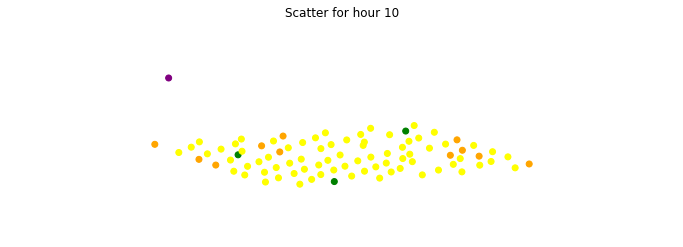

In [33]:
scatter_data.plot.scatter(x='latitud', y='longitud', c=color_data, title='Scatter for hour {}'.format(hour))
plt.scatter(scatter_data['latitud'], scatter_data['longitud'], c=color_data)
plt.title('Scatter for hour {}'.format(hour))
plt.axis('off')
#plt.legend()
plt.show()

# This is what i've done to correct date mistake in the original (v0) csv

In [34]:
'''SUMO_data = pd.read_csv(data_w_operacion_path)
SUMO_data'''

'SUMO_data = pd.read_csv(data_w_operacion_path)\nSUMO_data'

In [35]:
'''SUMO_data['fecha'] = SUMO_data['fecha_tiempo'].apply(lambda x: pd.Timestamp(x).date())
SUMO_data['hora'] = SUMO_data['fecha_tiempo'].apply(lambda x: pd.Timestamp(x).time())
SUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-11-09').date(),'fecha_tiempo'] = SUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-11-09').date(), 'hora'].apply(lambda x: pd.Timestamp.combine(pd.Timestamp(year=2019, month=9, day=11), x))
SUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-12-09').date(),'fecha_tiempo'] = SUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-12-09').date(), 'hora'].apply(lambda x: pd.Timestamp.combine(pd.Timestamp(year=2019, month=9, day=12), x))
SUMO_data.drop(['fecha','hora'], axis=1, inplace=True)
SUMO_data['fecha_tiempo'] = SUMO_data['fecha_tiempo'].apply(lambda x: pd.Timestamp(x))
SUMO_data'''

"SUMO_data['fecha'] = SUMO_data['fecha_tiempo'].apply(lambda x: pd.Timestamp(x).date())\nSUMO_data['hora'] = SUMO_data['fecha_tiempo'].apply(lambda x: pd.Timestamp(x).time())\nSUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-11-09').date(),'fecha_tiempo'] = SUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-11-09').date(), 'hora'].apply(lambda x: pd.Timestamp.combine(pd.Timestamp(year=2019, month=9, day=11), x))\nSUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-12-09').date(),'fecha_tiempo'] = SUMO_data.loc[SUMO_data.fecha == pd.Timestamp('2019-12-09').date(), 'hora'].apply(lambda x: pd.Timestamp.combine(pd.Timestamp(year=2019, month=9, day=12), x))\nSUMO_data.drop(['fecha','hora'], axis=1, inplace=True)\nSUMO_data['fecha_tiempo'] = SUMO_data['fecha_tiempo'].apply(lambda x: pd.Timestamp(x))\nSUMO_data"

In [36]:
#SUMO_data.to_csv(data_w_operacion_path,index=False)

.

.

.

.

.

.

# Just ouputs

In [37]:
#DF to process...
#You can put on data any filter you want. If you put only monday data all the graphs
#below will be for monday values...
data = SUMO_data.copy()
#data = weekday_data.copy()
#data = BD_parking_data.copy()

#Street to process...
#From 2 to 92 without 50
street = 2

#Date to process...
date_n = 1
date = modif_date(data, date_n)

#Hour to process...
#From 0 to 23
hour = 10

## Ocupation per street

### Top 10 ocupped streets

In [38]:
display(max_max_ocupacion)

,id_cuadra,direccion,ocupacion_max,lugares_cuadra
0,59,Yrigoyen 655,32,48.0
1,32,Sarmiento 453,27,27.0
2,14,Rodriguez 464,27,30.0
3,33,Sarmiento 755,23,32.0
4,75,Maipu 333,23,31.0
5,13,General Pinto 343,22,27.0
6,11,San Martín 658,22,30.0
7,4,Rodriguez 552,22,28.0
8,21,Belgrano 540,21,29.0
9,80,General Paz 447,21,36.0


### Top 10 less ocupped streets

In [39]:
display(less_max_ocupacion)

,id_cuadra,direccion,ocupacion_max,lugares_cuadra
0,92,Tribunal de Faltas,1,NaN
1,78,Maipu 953,5,14.0
2,85,Av. España 359,5,7.0
3,25,Belgrano 958,6,13.0
4,77,Maipu 857,6,15.0
5,55,14 de Julio 467,7,13.0
6,69,14 de Julio 657,7,10.0
7,88,Av. España 647,7,11.0
8,87,Av. España 545,8,10.0
9,41,Mitre 446,8,16.0


## Traffic per street (how much input-outputs)

In [40]:
display(min_traffic)
display(max_traffic)

,id_cuadra,direccion,in-outs
0,92,Tribunal de Faltas,7
1,77,Maipu 857,153
2,71,14 de Julio 847,161
3,78,Maipu 953,181
4,79,General Paz 347,217
5,24,Belgrano 868,218
6,70,14 de Julio 767,219
7,85,Av. España 359,225
8,25,Belgrano 958,243
9,40,Mitre 348,286


,id_cuadra,direccion,in-outs
0,59,Yrigoyen 655,1331
1,11,San Martín 658,1280
2,6,General Pinto 759,1219
3,4,Rodriguez 552,1173
4,45,Alem 480,1154
5,89,Av. España 737,1144
6,46,Alem 556,1091
7,5,9 de Julio 441,1079
8,33,Sarmiento 755,1057
9,22,Belgrano 768,1043


## Ocupation for a designated street along the day

### Graph for designated date

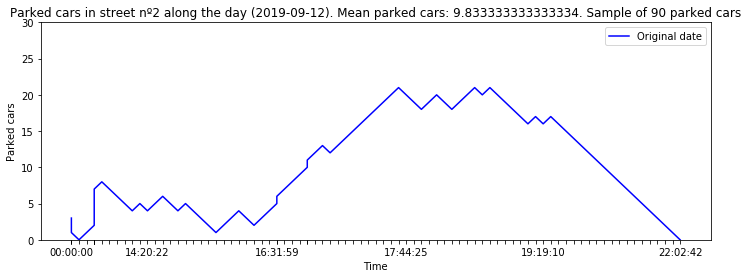

In [41]:
plot_line_graph(plot_data, date, street=street, max_ocup=max_ocup)

### Graph for the date with max mean of parked cars

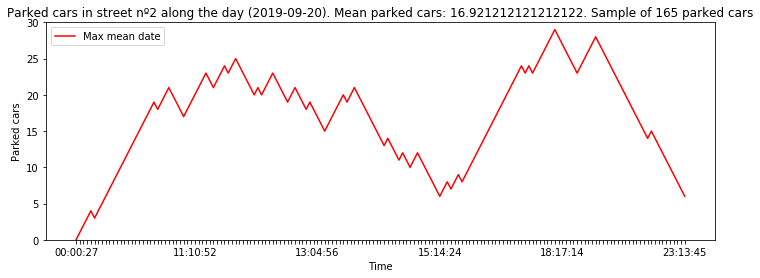

In [42]:
plot_line_graph(plot_data, date_max_mean, street=street, max_ocup=max_ocup, name='Max mean', color='r')

### Graph for the date with min mean of parked cars

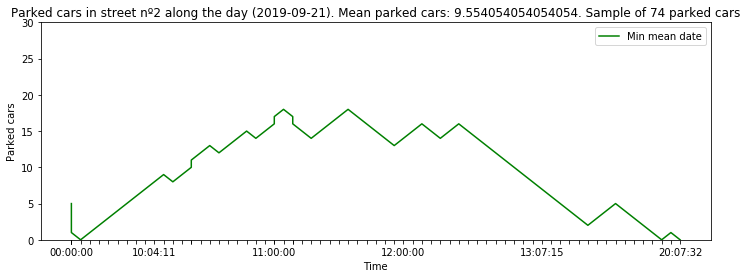

In [43]:
plot_line_graph(plot_data, date_min_mean, street=street, max_ocup=max_ocup, name='Min mean', color='g')

## In-outs per hour on each street

In [44]:
'''
in-out > 0: more entradas than salidas
in-out < 0: more salidas than entradas
'''
display(in_out_per_hour)

,id_cuadra,hora,entradas,salidas,in - out
0,2,7,1.000000,0.000000,1.000000
1,2,8,1.666667,1.000000,0.666667
2,2,9,5.333333,2.000000,3.333333
3,2,10,7.800000,3.500000,4.300000
4,2,11,4.777778,5.777778,-1.000000
...,...,...,...,...,...
1417,91,21,0.000000,2.000000,-2.000000
1418,91,22,0.000000,1.000000,-1.000000
1419,91,23,0.000000,4.000000,-4.000000
1420,92,8,0.000000,1.000000,-1.000000


## In-outs per hour on designated street

In [45]:
'''
in-out > 0: more entradas than salidas
in-out < 0: more salidas than entradas
'''
print(data.loc[data.id_cuadra == street, 'direccion'].iloc[0])

General Pinto 545


In [46]:
#First we display the in-out for the designated street orderer by the hora
display(in_out_per_hour.loc[in_out_per_hour['id_cuadra'] == street, ['hora','in - out']].reset_index(drop=True))

#And at the right we will display the in-out orderer by the in-out (ascendant)
display(in_out_per_hour.loc[in_out_per_hour['id_cuadra'] == street, ['hora','in - out']].sort_values(by='in - out').reset_index(drop=True))

,hora,in - out
0,7,1.000000
1,8,0.666667
2,9,3.333333
3,10,4.300000
4,11,-1.000000
5,12,0.000000
6,13,0.725000
7,14,-0.402778
8,15,-2.041667
9,16,1.055556


,hora,in - out
0,20,-2.333333
1,19,-2.333333
2,15,-2.041667
3,0,-2.000000
4,21,-1.000000
5,22,-1.000000
6,11,-1.000000
7,14,-0.402778
8,12,0.000000
9,8,0.666667


## Heat map

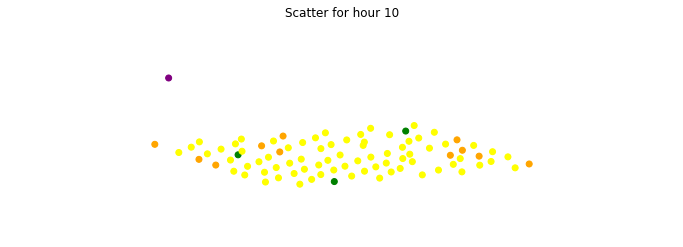

In [47]:
scatter_data = get_data_for_scatter_graph(data,hour)
color_data = get_color_for_scatter_graph(scatter_data)
scatter_data.plot.scatter(x='latitud', y='longitud', c=color_data, title='Scatter for hour {}'.format(hour))
plt.scatter(scatter_data['latitud'], scatter_data['longitud'], c=color_data)
plt.title('Scatter for hour {}'.format(hour))
plt.axis('off')
#plt.legend()
plt.show()